<a href="https://colab.research.google.com/github/sushgho/Msc-Project/blob/master/AI_Assisted_Sentiment_Analysis_of_Hotel_Reviews_Using_Topic_Modeling_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AI Assisted Sentiment Analysis of Hotel Reviews Using Topic Modeling**--Part 1

**Topic modeling with LDA**

**Libraries**

In [1]:
pip install pyLDAvis


     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 17.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=c48d27cd66c43989c19794042fe30e7c58e0deb05b2c9af49487b1c3eb14cfc8
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=f645e37ad31d7ac9b103339378935dee57dd6d1e55257b90aa065cc6ce9dee09
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


**Import Packages**

In [2]:

from pprint import pprint
import numpy as np
import os,re
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import nltk
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
#import unicodecsv
import re
import numpy as np

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Uploading Data file**

In [3]:
data = pd.read_csv('reviews_Hotel11.csv', engine='python',error_bad_lines=False,encoding='latin-1')

Printing the data

In [4]:
data.head()

,Review Rating,Review_Title,Topic
0,5.0,I had a pleasure of staying in this hotel for ...,Facilities Comfort Food Staff Location Service
1,5.0,A very lovely first visit to this iconic hotel...,Food Price Service
2,4.0,3 of us stayed at the Rhodes Hotel for 4 night...,Facilities Cleanliness Staff Location
3,5.0,Form the moment we arrived until we left we ex...,Food Staff Service
4,1.0,Well I am no strange to London's 5star hotels ...,Facilities Cleanliness Food Price Staff Service


In [5]:
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("great", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("room", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("stay", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("hotel", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("time", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("negative", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("Negative", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("positve", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("good", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("bad", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("small", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("go", ""))
data['Review_Title'] = data['Review_Title'].map(lambda x: str(x).replace("nice", ""))

data1 = data['Review_Title'][:300000].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


data1 = data1.values.tolist()

In [6]:
#data1

**Preprocessing**

In [7]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data1))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:0]]

[]

**LDA MODEL**

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, \
                               update_every=1, chunksize=10000, passes=1,minimum_probability=0)

In [15]:
# Prints the topics.
for top in lda_model.print_topics():
  print (top)


(0, '0.101*"staff" + 0.086*"location" + 0.063*"friendly" + 0.047*"helpful" + 0.047*"clean" + 0.036*"great" + 0.034*"comfortable" + 0.023*"room" + 0.017*"excellent" + 0.017*"breakfast"')
(1, '0.048*"location" + 0.047*"breakfast" + 0.034*"excellent" + 0.027*"staff" + 0.025*"restaurant" + 0.023*"price" + 0.019*"close" + 0.018*"value" + 0.018*"station" + 0.015*"money"')
(2, '0.015*"front" + 0.015*"walk" + 0.014*"pillow" + 0.012*"area" + 0.012*"desk" + 0.011*"place" + 0.011*"light" + 0.008*"street" + 0.008*"city" + 0.008*"also"')
(3, '0.055*"floor" + 0.043*"view" + 0.025*"lift" + 0.019*"could" + 0.017*"staff" + 0.013*"size" + 0.013*"big" + 0.012*"reception" + 0.011*"bath" + 0.010*"would"')
(4, '0.028*"positive" + 0.021*"location" + 0.020*"work" + 0.019*"shower" + 0.018*"night" + 0.016*"window" + 0.014*"door" + 0.013*"noise" + 0.013*"could" + 0.012*"room"')
(5, '0.024*"coffee" + 0.024*"clean" + 0.022*"breakfast" + 0.020*"comfortable" + 0.019*"shower" + 0.018*"bed" + 0.017*"location" + 0.016*

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.099027746861092

Coherence Score:  0.5958581197900771


**Building LDA model and finding coherence**

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

**Plot the coherence scores for different N topics**




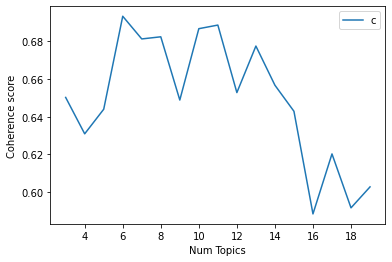

In [20]:
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.6502
Num Topics = 4  has Coherence Value of 0.6309
Num Topics = 5  has Coherence Value of 0.6439
Num Topics = 6  has Coherence Value of 0.6931
Num Topics = 7  has Coherence Value of 0.6811
Num Topics = 8  has Coherence Value of 0.6822
Num Topics = 9  has Coherence Value of 0.6488
Num Topics = 10  has Coherence Value of 0.6865
Num Topics = 11  has Coherence Value of 0.6884
Num Topics = 12  has Coherence Value of 0.6527
Num Topics = 13  has Coherence Value of 0.6773
Num Topics = 14  has Coherence Value of 0.6566
Num Topics = 15  has Coherence Value of 0.6428
Num Topics = 16  has Coherence Value of 0.5886
Num Topics = 17  has Coherence Value of 0.6203
Num Topics = 18  has Coherence Value of 0.5918
Num Topics = 19  has Coherence Value of 0.6029


**Printing Topics** 

In [22]:
max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]

# Select the model and print the topics
#optimal_model = model_list[max_index]
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))
optimal_model.save('optimal_model')

[(0,
  '0.028*"check" + 0.020*"book" + 0.015*"give" + 0.015*"reception" + '
  '0.014*"night" + 0.013*"ask" + 0.013*"take" + 0.013*"would" + 0.012*"even" + '
  '0.011*"leave"'),
 (1,
  '0.047*"drink" + 0.043*"food" + 0.035*"order" + 0.035*"wait" + '
  '0.034*"evening" + 0.030*"table" + 0.029*"serve" + 0.029*"long" + '
  '0.025*"dinner" + 0.020*"service"'),
 (2,
  '0.037*"light" + 0.024*"issue" + 0.019*"channel" + 0.019*"heating" + '
  '0.017*"cold" + 0.017*"euros" + 0.016*"minor" + 0.016*"work" + 0.015*"smoke" '
  '+ 0.014*"smell"'),
 (3,
  '0.052*"free" + 0.038*"wifi" + 0.037*"water" + 0.034*"double" + '
  '0.022*"towel" + 0.016*"provide" + 0.015*"single" + 0.013*"shower" + '
  '0.012*"twin" + 0.012*"complimentary"'),
 (4,
  '0.102*"coffee" + 0.078*"breakfast" + 0.065*"poor" + 0.029*"cold" + '
  '0.028*"fresh" + 0.027*"selection" + 0.021*"option" + 0.021*"buffet" + '
  '0.020*"include" + 0.017*"machine"'),
 (5,
  '0.114*"staff" + 0.080*"location" + 0.052*"breakfast" + 0.047*"friendly" 

**Dominant topic in each document and topic weight**

In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data1):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original Review text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','Review_Title'] # documents in a given topic has contributed to the most and infer the topic
dominent=df_dominant_topic
dominent[:500]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title
0,0,10.0,0.2093,"walk, close, station, easy, minute, train, cit...",pleasure this nights recently. This perfect ev...
1,1,11.0,0.3978,"amazing, definitely, would, recommend, wonderf...",very lovely first visit this iconic bar! Wonde...
2,2,5.0,0.3910,"staff, location, breakfast, friendly, helpful,...","Rhodes Hotel nights, location taking Paddingto..."
3,3,6.0,0.1827,"feel, make, always, special, smile, home, welc...",Form moment arrived until left experienced abs...
4,4,0.0,0.6617,"check, book, give, reception, night, ask, take...",Well strange London's 5star when comes along e...
...,...,...,...,...,...
495,495,0.0,0.4704,"check, book, give, reception, night, ask, take...",Although arrived comfortably after check-in we...
496,496,5.0,0.4323,"staff, location, breakfast, friendly, helpful,...",From moment checked moment left were treated l...
497,497,0.0,0.3686,"check, book, give, reception, night, ask, take...","checked many &amp; Breakfast sites ridiculous,..."
498,498,0.0,0.1931,"check, book, give, reception, night, ask, take...",have admit that very skeptical about newly re-...


In [24]:
dominent

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title
0,0,10.0,0.2093,"walk, close, station, easy, minute, train, cit...",pleasure this nights recently. This perfect ev...
1,1,11.0,0.3978,"amazing, definitely, would, recommend, wonderf...",very lovely first visit this iconic bar! Wonde...
2,2,5.0,0.3910,"staff, location, breakfast, friendly, helpful,...","Rhodes Hotel nights, location taking Paddingto..."
3,3,6.0,0.1827,"feel, make, always, special, smile, home, welc...",Form moment arrived until left experienced abs...
4,4,0.0,0.6617,"check, book, give, reception, night, ask, take...",Well strange London's 5star when comes along e...
...,...,...,...,...,...
299995,299995,5.0,0.3264,"staff, location, breakfast, friendly, helpful,...",sauna Jacuzzi Staff were very helpful with tou...
299996,299996,5.0,0.2948,"staff, location, breakfast, friendly, helpful,...",Poor wifi connection Staff cleanliness
299997,299997,5.0,0.3911,"staff, location, breakfast, friendly, helpful,...",minute walk closest metro Very Friendly staff ...
299998,299998,5.0,0.2764,"staff, location, breakfast, friendly, helpful,...",shower cold near beach metro station walking


In [ ]:

#df= pd.DataFrame(dominent)
#df.to_csv('dominent.txt')

In [25]:
sentiment=data['Review Rating']
#sentiment

In [26]:
dominent = dominent.join(sentiment)
dominent.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating
0,0,10.0,0.2093,"walk, close, station, easy, minute, train, cit...",pleasure this nights recently. This perfect ev...,5.0
1,1,11.0,0.3978,"amazing, definitely, would, recommend, wonderf...",very lovely first visit this iconic bar! Wonde...,5.0
2,2,5.0,0.3910,"staff, location, breakfast, friendly, helpful,...","Rhodes Hotel nights, location taking Paddingto...",4.0
3,3,6.0,0.1827,"feel, make, always, special, smile, home, welc...",Form moment arrived until left experienced abs...,5.0
4,4,0.0,0.6617,"check, book, give, reception, night, ask, take...",Well strange London's 5star when comes along e...,1.0


In [27]:
Doc_review=dominent[['Dominant_Topic' ,'Keywords','Review_Title','Review Rating']][:50]
Doc_review

,Dominant_Topic,Keywords,Review_Title,Review Rating
0,10.0,"walk, close, station, easy, minute, train, cit...",pleasure this nights recently. This perfect ev...,5.0
1,11.0,"amazing, definitely, would, recommend, wonderf...",very lovely first visit this iconic bar! Wonde...,5.0
2,5.0,"staff, location, breakfast, friendly, helpful,...","Rhodes Hotel nights, location taking Paddingto...",4.0
3,6.0,"feel, make, always, special, smile, home, welc...",Form moment arrived until left experienced abs...,5.0
4,0.0,"check, book, give, reception, night, ask, take...",Well strange London's 5star when comes along e...,1.0
5,5.0,"staff, location, breakfast, friendly, helpful,...","staff were very helpful, booked wrong mistake ...",5.0
6,0.0,"check, book, give, reception, night, ask, take...",Already stepping taxi that very special feelin...,5.0
7,5.0,"staff, location, breakfast, friendly, helpful,...",What incredibly cool place. most delicious int...,5.0
8,0.0,"check, book, give, reception, night, ask, take...","Savoy Savoy, every came back real surprise tha...",5.0
9,0.0,"check, book, give, reception, night, ask, take...",location next park close Harvey Harrods means ...,4.0


In [28]:
def label_theme(row):
    if row['Dominant_Topic'] == 0 :
        return 'Service'
    if row['Dominant_Topic'] == 1 :
        return 'Service, Food'
    if row['Dominant_Topic'] == 2 :
        return 'Comfort'
    if row['Dominant_Topic'] == 3:
        return 'Facilities'
    if row['Dominant_Topic']  == 4:
        return 'Food'
    if row['Dominant_Topic'] == 5:
        return 'Staff, Location'
    if row['Dominant_Topic'] == 6:
        return ' Service'
    if row['Dominant_Topic'] == 7:
        return 'Cleanliness'
    if row['Dominant_Topic'] == 8:
        return 'Food, Comfort'
    if row['Dominant_Topic'] == 9:
        return 'Service,Faciities'
    if row['Dominant_Topic'] == 10:
        return 'Service , Location'
    if row['Dominant_Topic'] == 11:
        return 'Staff, Location'    
    if row['Dominant_Topic'] == 12:
        return 'Price'
    
        
dominent['dominant_topic_Label'] = dominent.apply (lambda row: label_theme(row), axis=1)


In [29]:
df= pd.DataFrame(dominent)
df.to_csv('dominent1.txt')

In [30]:
from IPython.display import display, HTML

display(HTML(dominent[:100].to_html()))

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominant_topic_Label
0,0,10.0,0.2093,"walk, close, station, easy, minute, train, city, away, access, stop","pleasure this nights recently. This perfect every way. Communication with before prompt, very efficient. Checking breeze. through spectacular lobby with modern glass chandeliers take elevator your they gave upgrade junior suite, spectacular. walk-in closet size where could have there; served seven decor very refined, bath! Carrera marble floor heated throughout, rain shower for! Location, turned out, were minutes walk Trafalgar Square, very quiet. Right outside Embankment tube stop. would walk theater area numerous restaurants, many major sites, such London Westminster Abbey were within walking distance. buffet breakfast service every morning. pricy, rate included Couple nights, glass wine sitting front fire place lobby. used spa, which included rate, almost every night. After windchill sightseeing, steam sauna jacuzzi would soften weary muscles. have many star around world, this tops would return here heartbeat next London.",5.0,"Service , Location"
1,1,11.0,0.3978,"amazing, definitely, would, recommend, wonderful, back, love, visit, absolutely, family","very lovely first visit this iconic bar! Wonderful service, without being intrusive all! Very delicious cocktails just generally round, very indulgent experience. Well worth visiting only that 'once life' experience, though make sure feeling 'flush' doesn't come cheap!",5.0,"Staff, Location"
2,2,5.0,0.3910,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room","Rhodes Hotel nights, location taking Paddington Express from Heathrow. like location clost partk walking distance most locations. bath were compared American Hotels very clean. enjoyed free WIFI. owners staff were very friendly helpful with taxi's resturant recomendations. would there again.",4.0,"Staff, Location"
3,3,6.0,0.1827,"feel, make, always, special, smile, home, welcome, personal, detail, attention",Form moment arrived until left experienced absolute perfection service excellance every member Savoy staff. Famous personalise service rich heritage Savoy truly best world eating dining woud highly recommend Kaspers restaurant. ourselves cannot wait until return.,5.0,Service
4,4,0.0,0.6617,"check, book, give, reception, night, ask, take, would, even, leave",Well strange London's 5star when comes along eager try. heard about corinthia some friends work industry said their really something. Until incident there total June second nights about some cash from exchange money some dollars flying pretty soon. When came money felt light. When counted almost £1000 down. Obviously shocked contacted reception. They started investigation! Well couple days later checkout matter resolved. made bill full. Upon return London with manager Jean Louis. said matter still under investigation gave card touch. Nothing ever resolved. This does only boast best London best world. premium this reason expect premium service. This epically failed dented confidence industry. didn't even formal apology. It's lovely would have your risk over £500 night should there risk?,1.0,Service
5,5,5.0,0.3988,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room","staff were very helpful, booked wrong mistake they changed without hassle. staff were Greeted with glass prosecco lovely comfortable very comfortable. Would definitely there again.",5.0,"Staff, Location"
6,6,0.0,0.4727,"check, book, give, reception, night, ask, take, would, even, leave","Already stepping taxi that very special feeling welcome. friendly smile, helping hand with lot's attitude. ever organises this, very well done. front desk it's, almost everywhere, very complicated slow check-in. been done already when reserving difficult swipe card card? that's quickly fortten when using Restaurant. Everything smart comfy designed. servi

In [31]:
dominent.head(20)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominant_topic_Label
0,0,10.0,0.2093,"walk, close, station, easy, minute, train, cit...",pleasure this nights recently. This perfect ev...,5.0,"Service , Location"
1,1,11.0,0.3978,"amazing, definitely, would, recommend, wonderf...",very lovely first visit this iconic bar! Wonde...,5.0,"Staff, Location"
2,2,5.0,0.3910,"staff, location, breakfast, friendly, helpful,...","Rhodes Hotel nights, location taking Paddingto...",4.0,"Staff, Location"
3,3,6.0,0.1827,"feel, make, always, special, smile, home, welc...",Form moment arrived until left experienced abs...,5.0,Service
4,4,0.0,0.6617,"check, book, give, reception, night, ask, take...",Well strange London's 5star when comes along e...,1.0,Service
5,5,5.0,0.3988,"staff, location, breakfast, friendly, helpful,...","staff were very helpful, booked wrong mistake ...",5.0,"Staff, Location"
6,6,0.0,0.4727,"check, book, give, reception, night, ask, take...",Already stepping taxi that very special feelin...,5.0,Service
7,7,5.0,0.3196,"staff, location, breakfast, friendly, helpful,...",What incredibly cool place. most delicious int...,5.0,"Staff, Location"
8,8,0.0,0.2475,"check, book, give, reception, night, ask, take...","Savoy Savoy, every came back real surprise tha...",5.0,Service
9,9,0.0,0.2880,"check, book, give, reception, night, ask, take...",location next park close Harvey Harrods means ...,4.0,Service


**Reviews for each Topic**

In [32]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
#sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
sent_topics_outdf_grpd = dominent.groupby('Dominant_Topic')

#for i, grp in sent_topics_outdf_grpd:
#    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
#                                            grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
#                                            axis=0)
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                            grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ["Document_No",'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Review_Title","Review Rating","dominent_topic_Label"]
#sent_topics_sorteddf_mallet.columns = ["Dominant_Topic", "Keywords", "Review_Title","dominent_topic_Label"]
# Show

review=sent_topics_sorteddf_mallet
review.head(15)
#review['dominant_topic_Label'] = review.apply (lambda row: label_theme(row), axis=1)

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominent_topic_Label
0,33433,0.0,0.8865,"check, book, give, reception, night, ask, take, would, even, leave",Charged night that didn't booked through Booking.com kept telling contact Booking.com they didn'...,1.0,Service
1,264033,1.0,0.6055,"drink, food, order, wait, evening, table, serve, long, dinner, service",Having wait minutes Sunday morning breakfast tables guests wait minutes longer cooked breakfast ...,1.3,"Service, Food"
2,29630,2.0,0.9573,"light, issue, channel, heating, cold, euros, minor, work, smoke, smell",ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½...,4.0,Comfort
3,58885,3.0,0.5849,"free, wifi, water, double, towel, provide, single, shower, twin, complimentary",Superior there should have been fridge with possible mini part wardrobe should have space hangin...,3.1,Facilities
4,191664,4.0,0.6272,"coffee, breakfast, poor, cold, fresh, selection, option, buffet, include, machine",breakfast options were poor bread toast frozen loaf limited fruit options cooked breakfast items...,3.5,Food
5,162268,5.0,0.8437,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",Nothing Staff friendly helpful Clean with facilities ideal quiet location Room perfect really en...,5.1,"Staff, Location"
6,298782,6.0,0.6401,"feel, make, always, special, smile, home, welcome, personal, detail, attention",mina medel rnigt detta rnigt efter varit Hilton Sofitel ntningar rnigt nstren inte isolerade vin...,3.1,Service
7,22762,7.0,0.6627,"restaurant, area, many, bar, shop, convenient, nearby, cleanliness, business, lobby","slet ikke hvad foregår. Jeres anmeldelse lever slet ikke virkeligheden. værste slum. Beskidt, de...",1.0,Cleanliness
8,219105,8.0,0.6901,"positive, floor, work, window, door, night, open, shower, noise, sleep",buzzer kept waking every half hour didn sleep well lift wasn working lift heavy case down three ...,5.4,"Food, Comfort"
9,9901,9.0,0.6172,"view, pool, love, design, rooftop, beach, terrace, roof, amazing, cool","Prima zeer vriendelijke ontvangst welkomstdrankje, prachtige kamer zeer grote kamer. Alles keuri...",5.0,"Service,Faciities"


In [33]:
from IPython.display import display, HTML

display(HTML(review.to_html()))

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominent_topic_Label
0,33433,0.0,0.8865,"check, book, give, reception, night, ask, take, would, even, leave","Charged night that didn't booked through Booking.com kept telling contact Booking.com they didn't take responsibility. There confirmation emails calls booking. customer service.Myat After reviewing your reservations. show that were booked arrival 12/06/15 through third party website. should have received confirmation these bookings through third party booked them through. Unfortunately, nobody showed arrival 12/06, reservations were charged first night show.",1.0,Service
1,264033,1.0,0.6055,"drink, food, order, wait, evening, table, serve, long, dinner, service",Having wait minutes Sunday morning breakfast tables guests wait minutes longer cooked breakfast buffet food replenished Positive,1.3,"Service, Food"
2,29630,2.0,0.9573,"light, issue, channel, heating, cold, euros, minor, work, smoke, smell",ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½MOï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½Value moneyï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½,4.0,Comfort
3,58885,3.0,0.5849,"free, wifi, water, double, towel, provide, single, shower, twin, complimentary",Superior there should have been fridge with possible mini part wardrobe should have space hanging long items clothing without shelf bottom wardrobe stopping clothes hang fall without bottom screwing creasing clothes Twin beds Superior were very comfortable,3.1,Facilities
4,191664,4.0,0.6272,"coffee, breakfast, poor, cold, fresh, selection, option, buffet, include, machine",breakfast options were poor bread toast frozen loaf limited fruit options cooked breakfast items overdone Positive,3.5,Food
5,162268,5.0,0.8437,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",Nothing Staff friendly helpful Clean with facilities ideal quiet location Room perfect really enjoyed tasty breakfast really enjoyed,5.1,"Staff, Location"
6,298782,6.0,0.6401,"feel, make, always, special, smile, home, welcome, personal, detail, attention",mina medel rnigt detta rnigt efter varit Hilton Sofitel ntningar rnigt nstren inte isolerade vinden ylar genom sprinr biltrafiken mycket Termostaten rummet trasig vaktm staren sina nycklar rren derskan sitt kort rren inte kert Helt tsligt knackade rren person skulle fylla vatten minibaren hade varken vatten eller vagn aldrig minibaren Frukostbuff okej inte baconen tjocka ligt tillagade vattnig annansen durvalet tunt ostskivorna tjocka skurna kniv sagt rnor ntar klass kvalit Lobbyn hissarna personalen receptionen,3.1,Service
7,22762,7.0,0.6627,"restaurant, area, many, bar, shop, convenient, nearby, cleanliness, business, lobby","slet ikke hvad foregår. Jeres anmeldelse lever slet ikke virkeligheden. værste slum. Beskidt, defekt, fugtigt, skimmelsvamp. Ikke egnet beboelse. Ingen service",1.0,Cleanliness
8,219105,8.0,0.6901,"positive, floor, work, window, door, night, open, shower, noise, sleep",buzzer kept waking every half hour didn sleep well lift wasn working lift heavy case down three sets stairsNo Positive,5.4,"Food, Comfort"
9,9901,9.0,0.6172,"view, pool, love, design, rooftop, beach, terrace, roof, amazing, cool","Prima zeer vriendelijke 

Word cloud for Top words in Each topic

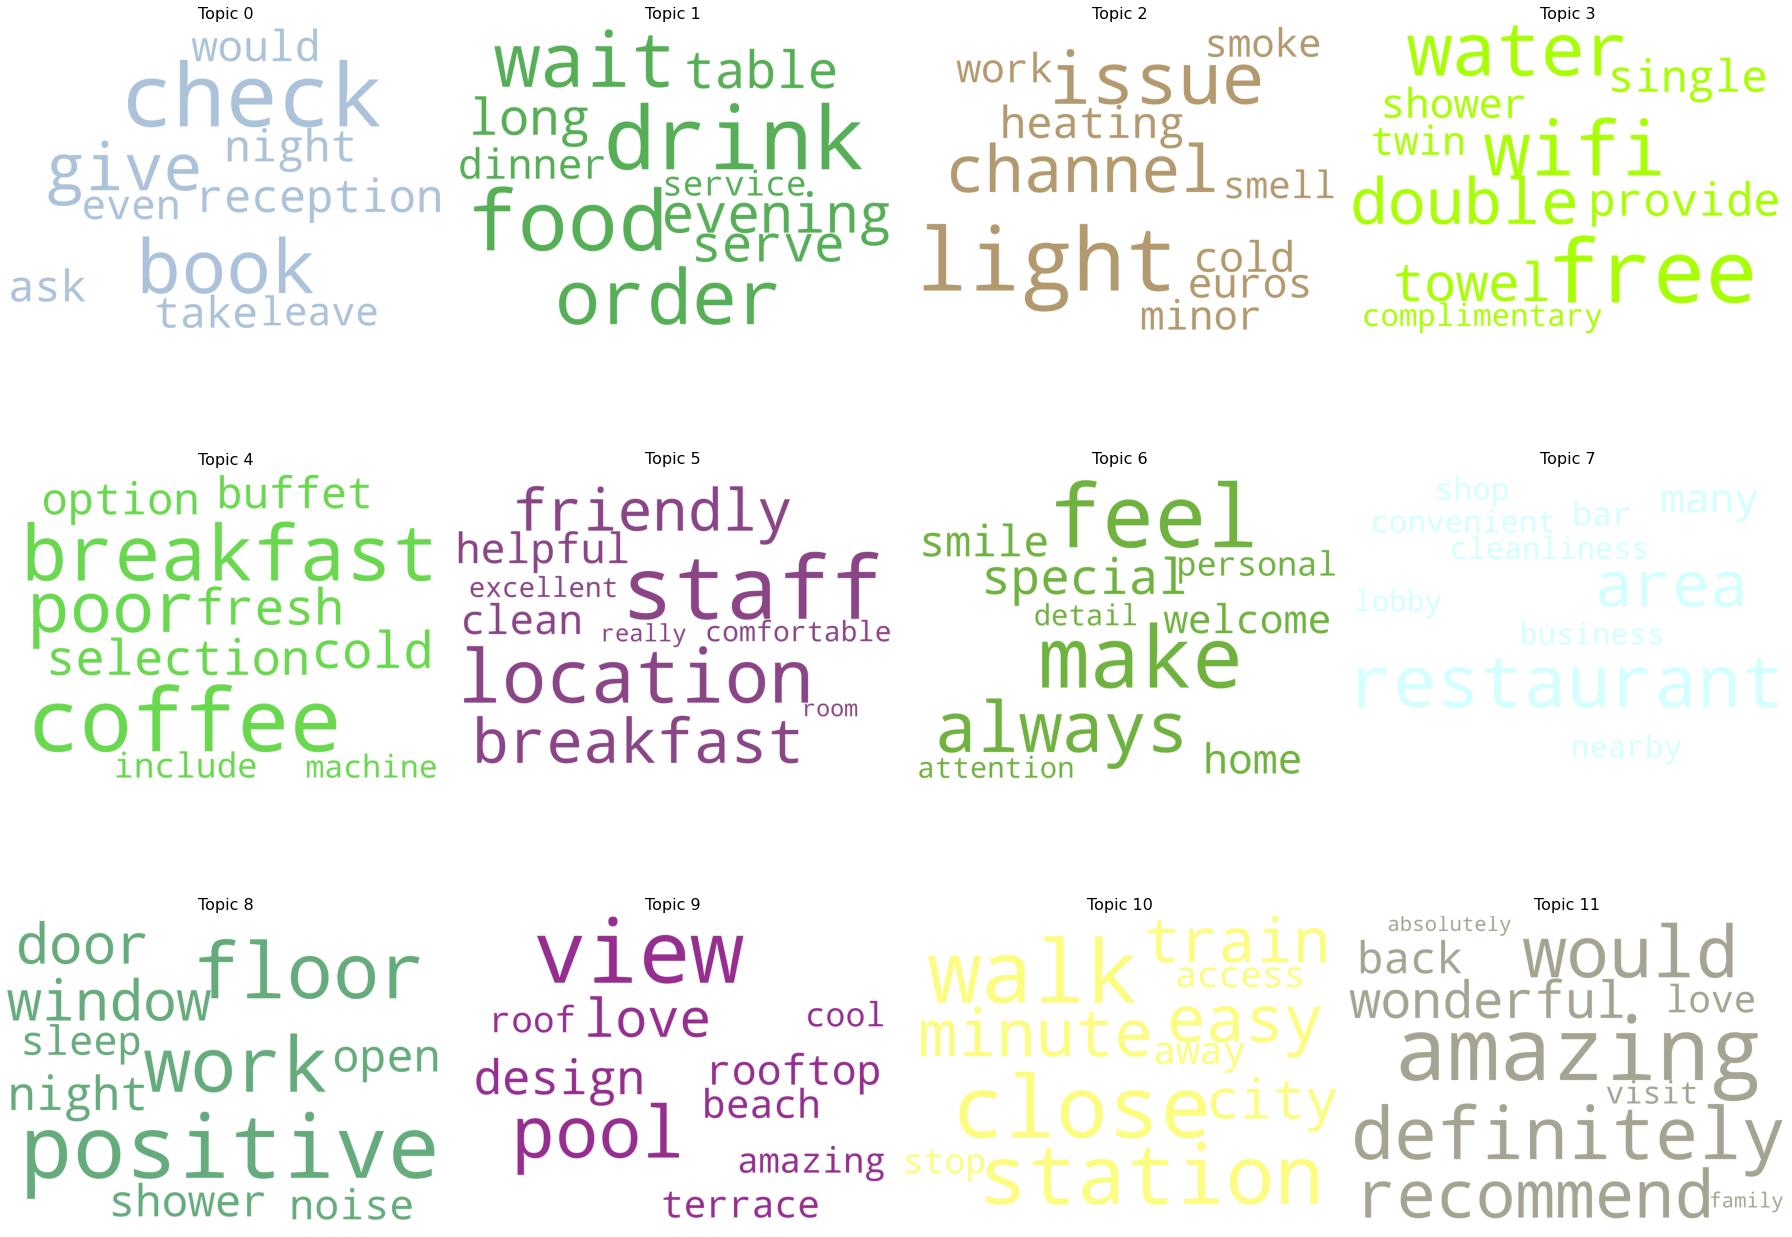

In [34]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=13, num_words=10)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(3, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [35]:
topics


[(0,
  [('check', 0.02784413),
   ('book', 0.019601358),
   ('give', 0.014902057),
   ('reception', 0.014767296),
   ('night', 0.013718318),
   ('ask', 0.013237219),
   ('take', 0.013147049),
   ('would', 0.012852463),
   ('even', 0.011866533),
   ('leave', 0.010924808)]),
 (1,
  [('drink', 0.0471483),
   ('food', 0.042842526),
   ('order', 0.035363495),
   ('wait', 0.03507367),
   ('evening', 0.033502817),
   ('table', 0.029503934),
   ('serve', 0.02913013),
   ('long', 0.028611554),
   ('dinner', 0.024812194),
   ('service', 0.019651674)]),
 (2,
  [('light', 0.03683516),
   ('issue', 0.023964928),
   ('channel', 0.019296825),
   ('heating', 0.01892561),
   ('cold', 0.017372046),
   ('euros', 0.016939124),
   ('minor', 0.016217908),
   ('work', 0.015787577),
   ('smoke', 0.0149143655),
   ('smell', 0.013850674)]),
 (3,
  [('free', 0.051880054),
   ('wifi', 0.0380348),
   ('water', 0.036519505),
   ('double', 0.033739187),
   ('towel', 0.022233265),
   ('provide', 0.016163403),
   ('si

**TSNE Clustering**

In [36]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [37]:
import plotly.express as px
import plotly.graph_objects as go


tsne_lda_df = pd.DataFrame(tsne_lda)
tsne_lda_df.columns = ['col1', 'col2']
tsne_lda_df['topic'] = df_dominant_topic['Dominant_Topic']
data = data.reset_index(drop=True)
#tsne_lda_df['label'] = raw_data['label']
tsne_lda_df['Review_Title'] = data['Review_Title']

tsne_lda_df['topic'] = tsne_lda_df['topic'].astype('object')

plt.set_cmap('tab20')
fig = px.scatter(tsne_lda_df, x='col1', y='col2', hover_name='Review_Title',
              color='topic',
              #facet_col='topic', 
                color_discrete_sequence=px.colors.carto.Bold)
#                   color_discrete_map={"0": "blue", "1": "green", "2":"red", "3":"yellow", "4":"magenta", "5":"cyan",
#                                      "6":"deepskyblue", "7":"lightcoral", "8":"darkorange", "9":"aquamarine",
#                                      "10":"peru", "11":"darkkhaki"})

fig.update_layout(
    title=go.layout.Title(
        text="TSNE representation of tcpdump data segregated by topics",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="TSNE Dim 1",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="TSNE Dim 2",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()

**Visualisation of Topics**

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.042749 -0.229081       1        1  19.697733
1      0.104096  0.009887       2        1   3.368383
2      0.071711  0.137624       3        1   2.213674
3      0.095595 -0.118633       4        1   5.416255
4      0.267381  0.054530       5        1   3.414572
5      0.043299 -0.120777       6        1  28.787788
6     -0.217584 -0.035617       7        1   3.371367
7     -0.017380  0.281300       8        1   3.967366
8      0.045723 -0.108913       9        1   9.075030
9     -0.208320  0.220467      10        1   2.331095
10    -0.030259  0.040401      11        1   8.712873
11    -0.243593 -0.127492      12        1   5.507332
12     0.132080 -0.003695      13        1   4.136534, topic_info=           Term           Freq          Total Category  logprob  loglift
107       staff  156052.000000  156052.000000  Default  30.0000  30.0000
2     breakfast   87187.000000   87187.000000  Default  29.0000  29.0000
24     location  108688.000000  108688.000000  Default  28.0000  28.0000
46   restaurant   29599.000000   29599.000000  Default  27.0000  27.0000
100    friendly   63065.000000   63065.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
298       think     875.846008    8475.339844  Topic13  -5.3953   0.9156
233       level     684.637817    2832.858887  Topic13  -5.6416   1.7652
164      pretty     660.496277    3415.758057  Topic13  -5.6775   1.5421
441        seem     663.467407    6483.311035  Topic13  -5.6730   0.9058
355       offer     654.771729    8514.156250  Topic13  -5.6862   0.6201

[754 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
323      12  0.999820  absolutely
635      11  0.999872      access
934       7  0.996879  accomodate
2940      6  0.996908      accord
3301      9  0.997938     account
...     ...       ...         ...
902       7  0.181043        year
902       9  0.028404        year
902      11  0.000247        year
902      12  0.249459        year
902      13  0.022723        year

[1797 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [66]:
reviews = pd.read_csv('dominent1.txt', engine='python',error_bad_lines=False)
reviews.astype(str)

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominant_topic_Label
0,0,0,10.0,0.2092999964952469,"walk, close, station, easy, minute, train, city, away, access, stop","pleasure this nights recently. This perfect every way. Communication with before prompt, very ef...",5.0,"Service , Location"
1,1,1,11.0,0.3977999985218048,"amazing, definitely, would, recommend, wonderful, back, love, visit, absolutely, family","very lovely first visit this iconic bar! Wonderful service, without being intrusive all! Very de...",5.0,"Staff, Location"
2,2,2,5.0,0.3910000026226044,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room","Rhodes Hotel nights, location taking Paddington Express from Heathrow. like location clost partk...",4.0,"Staff, Location"
3,3,3,6.0,0.1826999932527542,"feel, make, always, special, smile, home, welcome, personal, detail, attention",Form moment arrived until left experienced absolute perfection service excellance every member S...,5.0,Service
4,4,4,0.0,0.6617000102996826,"check, book, give, reception, night, ask, take, would, even, leave",Well strange London's 5star when comes along eager try. heard about corinthia some friends work ...,1.0,Service
...,...,...,...,...,...,...,...,...
299995,299995,299995,5.0,0.3264000117778778,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",sauna Jacuzzi Staff were very helpful with tourist details directions,5.0,"Staff, Location"
299996,299996,299996,5.0,0.2948000133037567,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",Poor wifi connection Staff cleanliness,4.1,"Staff, Location"
299997,299997,299997,5.0,0.3910999894142151,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",minute walk closest metro Very Friendly staff very,5.1,"Staff, Location"
299998,299998,299998,5.0,0.27639999985694885,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",shower cold near beach metro station walking,3.5,"Staff, Location"


In [91]:
r2=reviews[['Review_Title','dominant_topic_Label']]


In [71]:
#pos tagging
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [73]:

def preProcess(text):
    # should return a list of tokens
    
    # word tokenisation, including punctuation removal
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # lowercasing
    tokens = [t.lower() for t in tokens]

    # stopword removal- benefits are it removes rare words, though bad for bigram relations
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop]

    # remove numbers and empty space
    digits = '0123456789'
    text = [t for t in text if t not in digits]
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    tokens = [t for t in tokens if t] # ensure no empty space
    
    return tokens

In [76]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [86]:
Processing=reviews['Review_Title']
#reviews['processed'] = Processing.apply(preProcess)

reviews.astype(str)

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Review_Title,Review Rating,dominant_topic_Label
0,0,0,10.0,0.2092999964952469,"walk, close, station, easy, minute, train, city, away, access, stop","pleasure this nights recently. This perfect every way. Communication with before prompt, very ef...",5.0,"Service , Location"
1,1,1,11.0,0.3977999985218048,"amazing, definitely, would, recommend, wonderful, back, love, visit, absolutely, family","very lovely first visit this iconic bar! Wonderful service, without being intrusive all! Very de...",5.0,"Staff, Location"
2,2,2,5.0,0.3910000026226044,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room","Rhodes Hotel nights, location taking Paddington Express from Heathrow. like location clost partk...",4.0,"Staff, Location"
3,3,3,6.0,0.1826999932527542,"feel, make, always, special, smile, home, welcome, personal, detail, attention",Form moment arrived until left experienced absolute perfection service excellance every member S...,5.0,Service
4,4,4,0.0,0.6617000102996826,"check, book, give, reception, night, ask, take, would, even, leave",Well strange London's 5star when comes along eager try. heard about corinthia some friends work ...,1.0,Service
...,...,...,...,...,...,...,...,...
299995,299995,299995,5.0,0.3264000117778778,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",sauna Jacuzzi Staff were very helpful with tourist details directions,5.0,"Staff, Location"
299996,299996,299996,5.0,0.2948000133037567,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",Poor wifi connection Staff cleanliness,4.1,"Staff, Location"
299997,299997,299997,5.0,0.3910999894142151,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",minute walk closest metro Very Friendly staff very,5.1,"Staff, Location"
299998,299998,299998,5.0,0.27639999985694885,"staff, location, breakfast, friendly, helpful, clean, comfortable, excellent, really, room",shower cold near beach metro station walking,3.5,"Staff, Location"


IndexingError: ignored